# Identifying Factors for User Adoption

The dataset is stored in two csv files, one for 12,000 users who signed up for the product in the last two years.  The fields in this table include:
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
- PERSONAL_PROJECTS: invited to join another user's personal workspace
- GUEST_INVITE: invited to an organization as a guest (limited permissions)
- ORG_INVITE: invited to an organization (as a full member)
- SIGNUP: signed up via the website
- SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

The second dataset is a usage summary table that has a row for each day that a user logged into the product.  

An adopted user is a user who has logged into the product on three separate days in at least one seven-day period.

The goal is to identify which features predict a future adopted user.

### Create a Pandas DataFrames 

The csv files are read into Pandas DataFrames.

In [1]:
import pandas as pd

users=pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement=pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [2]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Finding adopted users

An adopted user is a user who has logged into the product on three separate days in at least one seven-day period.  All unique users that logged in were found and then their logins over all seven day periods were counted using the pandas rolling function.  If maximum value for the users login count in seven days was above three days, the user would be considered an adopted user. 

In [4]:

unique_users=set(engagement['user_id']) #unique_users
adopted_user=[]

#use a rolling function in pandas to count the number of logins in a 7 day period for all users
for i, user in enumerate(unique_users):
    unique_user=engagement[engagement.user_id==user]
    unique_user=unique_user[['time_stamp', 'user_id']]
    unique_user['time_stamp']=pd.to_datetime(unique_user['time_stamp'])
    unique_user=unique_user.set_index('time_stamp')
    unique_user['at_least_3_days_over_7_days_period'] = unique_user.rolling(window = '7D').count()

#check if the number of logins per week is at least 3    
    if max(unique_user['at_least_3_days_over_7_days_period']) >=3:
        adopted_user.append(user)

        




Below is the percentage of users that logged in that are adopted users

In [5]:
print('Percentage of users that logged in that are adopted users: ' + str(len(adopted_user)/len(unique_users)*100))


Percentage of users that logged in that are adopted users: 18.157089425365523


### Join Adopted User Feature with Users DataFrame

The adopted user feature, the variable to be predicted was added to the dataFrame containing information on all user signups.

In [6]:
users['adopted_user']=[1 if i in adopted_user else 0 for i in users['object_id']]
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


### Drop Features that are unique for each user  and contain personal information

Features that were unique to each entry were dropped as they contain personal information and do not generalize the data so that a feature can be identified for predicting user adoption.  

In [7]:
users=users.drop(['object_id', 'name', 'email'], axis=1)

### Create Dummy Features and Convert datetime object into timestamp for creation_time feature

The method of signup feature, a categorical feature with 5 values was converted into dummy features.  Missing values were handled by replacing them with -1 so they are farther away in a vector space from filled in values when the prediction model is used.  The datetime when a user created their account was in a datetime object that was converted to a unix timestamp just so that the last session creation time would be in the same units.  

In [8]:
import numpy as np

users.head(5)

result = pd.concat([pd.get_dummies(users['creation_source']), users], axis=1, sort=False).drop(['creation_source'], axis=1)
result=result.fillna(-1)
result['creation_time']=pd.to_datetime(result['creation_time'])
result['creation_time'] = result.creation_time.values.astype(np.int64) // 10 ** 9



In [9]:
result.head(5)

,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,0,0,0,0,1398138810,1.398139e+09,1,0,11,10803.0,0
1,0,1,0,0,0,1384487104,1.396238e+09,0,0,1,316.0,1
2,0,1,0,0,0,1363734892,1.363735e+09,0,0,94,1525.0,0
3,1,0,0,0,0,1369123768,1.369210e+09,0,0,1,5151.0,0
4,1,0,0,0,0,1358417660,1.358850e+09,0,0,193,5240.0,0


## Exploratory Data Analysis 

All of the features except for time of user account creation and time of last user session were explored as these features had too many unique values and feature engineering would have been needed to create meaningful units such as month and day of the week.  These features can be explored in a later iteration of the exercise.

### Adopted User Rate by Guest Invited or Not Guest Invited

The adopted user rate by whether the user was invited by a guest or not was graphed below.  There was approximately a 4% increase adoption user rate when the user was invited by a guest.  This feature will be used in the prediction model. 

In [10]:
import matplotlib.pyplot as plt
guest_invite=result.groupby('GUEST_INVITE').mean()['adopted_user']

guest_invite.plot(kind='bar', title='Adopted User Rate by Guest Invite and Not Guest Invite')
plt.xticks(range(2), ('Not Guest Invite', 'Guest Invite'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(guest_invite)

<Figure size 640x480 with 1 Axes>

GUEST_INVITE
0    0.126258
1    0.166436
Name: adopted_user, dtype: float64


### Adopted User Rate by Org Invite and Not Org Invite

The adopted user rate when a user was invited by an org and when they were not invited by an org was graphed below.  The difference between adopted user rates in the two groups is minimal but will still be used as a feature in the prediction model.  

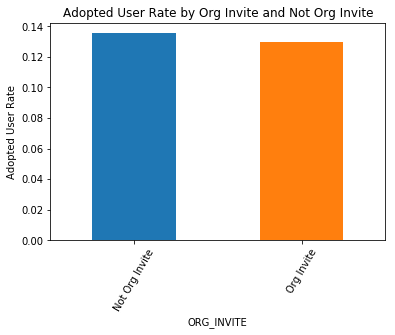

ORG_INVITE
0    0.135425
1    0.129995
Name: adopted_user, dtype: float64


In [11]:
org_invite=result.groupby('ORG_INVITE').mean()['adopted_user']

org_invite.plot(kind='bar', title='Adopted User Rate by Org Invite and Not Org Invite')
plt.xticks(range(2), ('Not Org Invite', 'Org Invite'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(org_invite)

### Adopted User Rate by Personal Project and not Personal Project

The adopted user rate when the user signed up because of a personal project and when they did not sign up because of a personal project is graphed below.  The difference in adopted user rate is significantly higher when the user is not signing up because of a personal project.  The difference is approximately 7%.  This feature will be used in the prediction model.

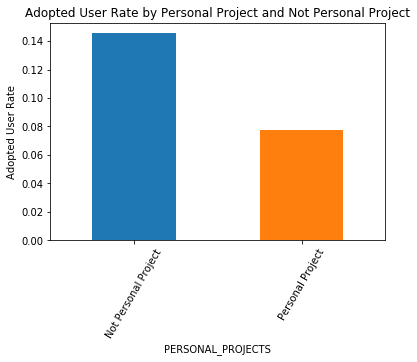

PERSONAL_PROJECTS
0    0.145414
1    0.077688
Name: adopted_user, dtype: float64


In [12]:
personal_projects=result.groupby('PERSONAL_PROJECTS').mean()['adopted_user']

personal_projects.plot(kind='bar', title='Adopted User Rate by Personal Project and Not Personal Project')
plt.xticks(range(2), ('Not Personal Project', 'Personal Project'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(personal_projects)

### Adopted User Rate by Signup and Not Signup

The adopted user rate when the user signed up by themselves and when the user did not sign up by themselves was minimally at a less than 1% difference.  

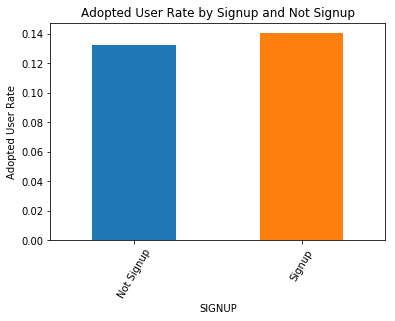

SIGNUP
0    0.132049
1    0.140393
Name: adopted_user, dtype: float64


In [13]:
sign_up=result.groupby('SIGNUP').mean()['adopted_user']

sign_up.plot(kind='bar', title='Adopted User Rate by Signup and Not Signup')
plt.xticks(range(2), ('Not Signup', 'Signup'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(sign_up)

### Adopted User Rate SIGNUP_GOOGLE_AUTH or Not SIGNUP_GOOGLE_AUTH

The adopted user rate of a user signing up with a google authorization is approximately 4% higher than when the user does not sign up with a google authorization.  This feature will be used in the prediction model. 

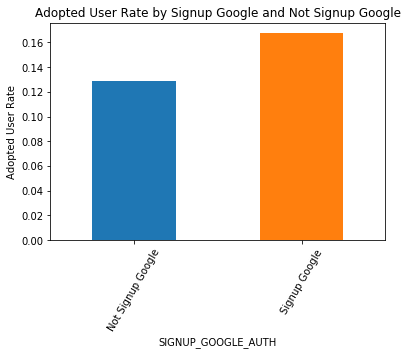

SIGNUP_GOOGLE_AUTH
0    0.129063
1    0.167509
Name: adopted_user, dtype: float64


In [14]:
sign_up_google=result.groupby('SIGNUP_GOOGLE_AUTH').mean()['adopted_user']

sign_up_google.plot(kind='bar', title='Adopted User Rate by Signup Google and Not Signup Google')
plt.xticks(range(2), ('Not Signup Google', 'Signup Google'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(sign_up_google)

### Adopted User Rate by On Mailing List and Not on Mailing List

The adopted user rate when the user was on the mailing list was around 0.7% higher.  The adopted user rates for each group can be seen below.

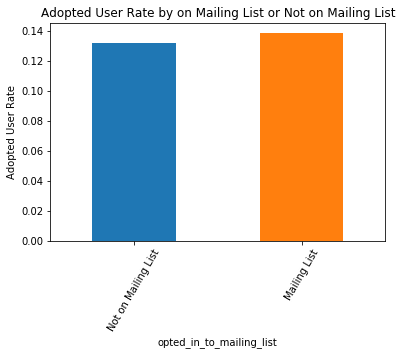

opted_in_to_mailing_list
0    0.131912
1    0.138277
Name: adopted_user, dtype: float64


In [15]:
mailing_list=result.groupby('opted_in_to_mailing_list').mean()['adopted_user']

mailing_list.plot(kind='bar', title='Adopted User Rate by on Mailing List or Not on Mailing List')
plt.xticks(range(2), ('Not on Mailing List', 'Mailing List'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(mailing_list)

### Adopted User Rate by On Marketing Drip and Not on Marketing Drip

The adopted user rate when a marketing drip was used on a user when it was not is small in difference at a less than 1% difference.  

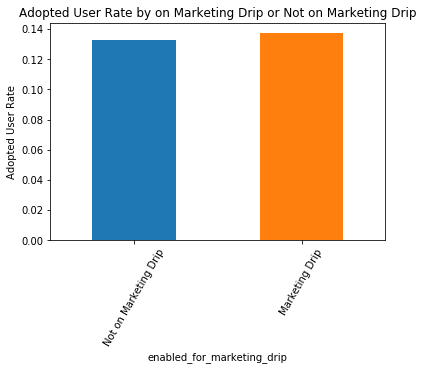

enabled_for_marketing_drip
0    0.132837
1    0.137277
Name: adopted_user, dtype: float64


In [16]:
marketing_drip=result.groupby('enabled_for_marketing_drip').mean()['adopted_user']

marketing_drip.plot(kind='bar', title='Adopted User Rate by on Marketing Drip or Not on Marketing Drip')
plt.xticks(range(2), ('Not on Marketing Drip', 'Marketing Drip'), rotation=60)
plt.ylabel('Adopted User Rate')
plt.show()

print(marketing_drip)

### Adopted User Count by Org ID Invite

The adopted user count is signicantly higher in the first 30 orgs than any other subgroup and can be seen in the early spike of the density plot below.  Invitation by org id will be used as a feature in the prediction model.  

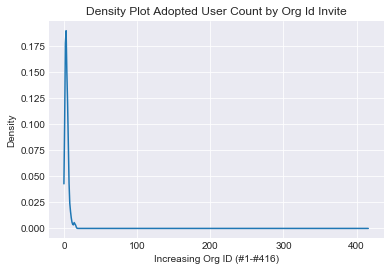

Mean Adopted User Count by Org ID: 3.84
Max Adopted User Count by Org ID: 16
Min Adopted User Count by Org ID: 0
Standard Deviation of Adopted User Count by Org ID: 2.6


In [131]:
fig, ax= plt.subplots()
org_id=result.groupby('org_id').sum()['adopted_user']
org_id.plot.kde(title='Density Plot Adopted User Count by Org Id Invite', ind=org_id.index)
plt.ylabel('Density')
plt.xlabel('Increasing Org ID (#1-#416)')
plt.show()

print('Mean Adopted User Count by Org ID: ' + str(round(org_id.mean(), 2)))
print('Max Adopted User Count by Org ID: ' + str((org_id).max()))
print('Min Adopted User Count by Org ID: ' + str(org_id.min()))
print('Standard Deviation of Adopted User Count by Org ID: ' + str((round(org_id.std(), 2))))


### Adopted User Count by User ID Invite

The density plot of adopted user count by user ID invite is seen below and after further inspection, all of the adopted user count density can be aggregated by summing the densities of the first 15 user ids (#1-15).  This feature will be used in the predictive model.

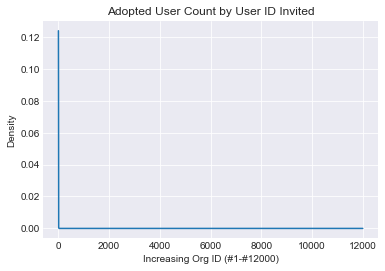

Mean Adopted User Count by User ID: 0.624561403508772
Max Adopted User Count by User ID: 689
Min Adopted User Count by User ID: 0
Standard Deviation of Adopted User Count by User ID: 13.611323126390555


In [129]:
user_invited=result.groupby('invited_by_user_id').sum()['adopted_user']

user_invited.plot.kde(title='Adopted User Count by User ID Invited', ind=user_invited.index)
plt.ylabel('Density')
plt.xlabel('Increasing Org ID (#1-#12000)')

plt.show()

print('Mean Adopted User Count by User ID: ' + str(user_invited.mean()))
print('Max Adopted User Count by User ID: ' + str(max(user_invited)))
print('Min Adopted User Count by User ID: ' + str(user_invited.min()))
print('Standard Deviation of Adopted User Count by User ID: ' + str(user_invited.std()))

## Prediction Task with Gradient Boosted Classifier

The adopted user status was predicted using an extreme gradient boosting tree method.  All of the features in the user signup dataFrame were used in the model.  A train test split of 0.8/0.2 was used and 5 folds were used in cross validation.

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X=result.drop(["adopted_user"], axis=1, inplace=False)
y=result["adopted_user"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

steps=[('gradientboost', XGBClassifier())]  #steps of pipeline
pipeline=Pipeline(steps) 
parameters_grad={}

print("Fitting a gradient boosted classifier to labeled training data...")


clf_gb = GridSearchCV(pipeline, parameters_grad, cv=5)  #Gridsearch object

clf_gb.fit(X_train, y_train)  #fit 

y_pred_gb=clf_gb.predict(X_test)  #predict


Fitting a gradient boosted classifier to labeled training data...


### Feature Importance of Model

The top 5 most important features in the model were in order:

1.) Account Creation Time
2.) Last Session Creation Time
3.) Org ID
4.) Invited by User ID
5.) Enabled for Marketing Drip

Although the gradient boosted model does not tell us which values of account creation time and last session creation time are causing adopted user rate, a logistic regression model can be used to find the sign of the coefficient for these features.  The sign will give a clue as to how the probability of becoming an adopted user changes as account creation time and last session creation time increase.  In the future, if certain days of the week or months want to be checked for their affect on user adoption, the features for each category can be engineered from the datetime values.  

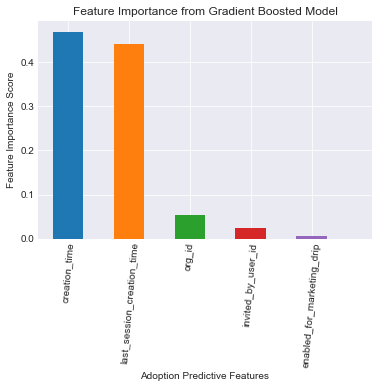

In [20]:
import seaborn as sns 
# Plot the feature importances for our target label of adopted users 
data=sorted(list(zip(X.columns, clf_gb.best_estimator_.steps[-1][1].feature_importances_)), key=lambda x: x[1], reverse=True)[0:5]
df = pd.DataFrame(data)
df=df.rename({0:'Feature', 1:'Importance Score'}, axis=1)

df.set_index(['Feature'])

sns.set_style("darkgrid")

df
df['Importance Score'].plot(kind='bar')
xcol = X.columns

plt.title('Feature Importance from Gradient Boosted Model')
plt.xlabel('Adoption Predictive Features')
plt.ylabel('Feature Importance Score')
plt.xticks(range(6), df.Feature[0:5], rotation=85)
plt.show()




### Model Accuracy 

The model accuracy is high and it appears that using all of the features did not lead to massive overfitting of the model.

In [21]:
from sklearn.metrics import accuracy_score
print('Accuracy: ' + str(round(accuracy_score(y_test, y_pred_gb) * 100, 4))+ '%')

Accuracy: 97.4167%
